# トラカンデータの前処理
- author
    - 松永
- ref
    - `../1_0_traffic_deleteNULLcols_930.ipynb`
- Input
    - 生トラカンデータに対し、文字コード変換・ヘッダの除去をシェルで加えたデータ
        - ref: `./handle_raw.ipynb`
    - 代表トラカン: `raw_<道路名>_<期間>.csv`
    - 2kmトラカン: `raw_<道路名>_<期間>_2KP.csv`
- Output
    - 代表トラカン: `<道路名>_<期間>.csv`
    - 2kmトラカン: `<道路名>_<期間>_2KP.csv`

In [1]:
import datetime as dt
import jpholiday

import cudf
import cupy
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd

# cupy.cuda.Device(1).use()
# plt.rcParams['font.family'] = 'Noto Sans JP'

In [2]:
PROCESSED_DATA_DIR = '../../Input_processed_data'

IC_CSV = f'{PROCESSED_DATA_DIR}/road_master/ic_preprocessed.csv'
IC_SUBNET_CSV = f'{PROCESSED_DATA_DIR}/road_master/icnet_sub.csv'

# TARGET_ROAD = 'kannetsu'
TARGET_ROAD = 'touhoku'
PERIOD = '20240507-20240831'

TRAFFIC_CSV =f'{PROCESSED_DATA_DIR}/traffic/raw_{TARGET_ROAD}_{PERIOD}_2KP.csv'

In [3]:
df_traffic = pd.read_csv(TRAFFIC_CSV).astype({'年': str, '月': str, '日': str})
df_traffic.head()

/opt/conda/envs/rapids/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (22,28,34,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,支社,区分,道路,年,月,日,曜日,平休1,平休2（休日に土曜日含む）,時刻,...,車線率(追),OCC(追),速度(追),エラー数.2,全車(路),大車(路),車線率(路),OCC(路),速度(路),エラー数.3
0,関東支社,速度ループ,東北自動車道,2024,5,7,火,平,平,0:0,...,26.2,3.0,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,関東支社,速度ループ,東北自動車道,2024,5,7,火,平,平,0:5,...,27.0,3.0,95.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,関東支社,速度ループ,東北自動車道,2024,5,7,火,平,平,0:10,...,24.4,2.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,関東支社,速度ループ,東北自動車道,2024,5,7,火,平,平,0:15,...,15.3,1.0,103.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,関東支社,速度ループ,東北自動車道,2024,5,7,火,平,平,0:20,...,19.5,1.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 欠損処理

### 車線情報の欠損状況から車線数をカウント

In [4]:
def add_lane_count(df: pd.DataFrame) -> pd.DataFrame:
    lane_cols = ['全車(1)', '全車(2)', '全車(追)','全車(路)']
    df.loc[:, 'lane_count'] = len(lane_cols) - df.loc[:, lane_cols].isna().sum(axis=1)
    return df

In [5]:
df_traffic = add_lane_count(df_traffic)

df_traffic.lane_count.value_counts()

3    3161700
2    1517220
0     139668
4     101016
1      67404
Name: lane_count, dtype: int64

### エラーの多いカラムを削除

In [6]:
DROP_COLS = [
    'エラー数', '全車(2)', '大車(2)', '車線率(2)', 'OCC(2)', '速度(2)', 'エラー数.1', 
    'エラー数.2', '全車(路)', '大車(路)', '車線率(路)', 'OCC(路)', '速度(路)','エラー数.3'
]
df_traffic.drop(DROP_COLS, axis=1, inplace=True)

## 新たに開業した区間を従来の表記に戻す
- 2023年9月10日「都賀西方スマートIC」の開業に伴い、2023年10月1日以降のトラカンデータにおいて、従来は「栃木都賀JCT～鹿沼」だった区間が2つに分割された
- 分割された区間「栃木都賀JCT〜都賀西方スマートIC」「都賀西方スマートIC〜鹿沼」それぞれの区間名称を2023年10月以前と同じ「栃木都賀JCT～鹿沼」表記に置き換える

In [7]:
start = '栃木都賀ＪＣＴ'
end = '鹿沼'
mid_new = '都賀西方スマートＩＣ'

In [8]:
cond = (
    (df_traffic.区間名称 == f'{start}　〜　{mid_new}')
    | (df_traffic.区間名称 == f'{mid_new}　〜　{end}')
)
df_traffic.loc[cond, '区間名称'] = f'{start}　〜　{end}'

In [9]:
assert (df_traffic.区間名称 == f'{start}　〜　{mid_new}').sum() == 0
assert (df_traffic.区間名称 == f'{mid_new}　〜　{end}').sum() == 0

## 2kmピッチにトラカンが設置している区間のみに限定
- 2kmピッチにトラカンが設置されている区間の集合は`traffic_counter_segments_2KP.pkl`に保存されている
- 2023/8/16以前のデータに関して、↑の区間に限定する

In [10]:
import pickle

with open('traffic_counter_segments_2KP.pkl', 'rb') as f:
    tc_segments_dict = pickle.load(f)

In [11]:
tc_segments_inbound = tc_segments_dict[TARGET_ROAD]['上り']
tc_segments_outbound = tc_segments_dict[TARGET_ROAD]['下り']

In [12]:
cond_inbound = (df_traffic.方向 == '上り') & (df_traffic.区間名称.isin(tc_segments_inbound))
cond_outbound =  (df_traffic.方向 == '下り') & (df_traffic.区間名称.isin(tc_segments_outbound))

df_tmp = df_traffic.loc[cond_inbound | cond_outbound].reset_index(drop=True)

# test
assert set(df_tmp.loc[df_tmp.方向 == '上り', '区間名称'].drop_duplicates()) == tc_segments_inbound
assert set(df_tmp.loc[df_tmp.方向 == '下り', '区間名称'].drop_duplicates()) == tc_segments_outbound

In [13]:
df_traffic = df_tmp

## 準備

In [14]:
usecols = ['年', '月', '日', '時刻', '方向', 'KP', '区間名称', '全車', 'OCC', '速度', 'lane_count']

df_traffic = df_traffic.loc[:, usecols]
df_traffic.head()

,年,月,日,時刻,方向,KP,区間名称,全車,OCC,速度,lane_count
0,2024,5,7,0:0,上り,5.6,浦和 〜 岩槻,141.0,6.0,80.0,3
1,2024,5,7,0:5,上り,5.6,浦和 〜 岩槻,137.0,5.0,85.0,3
2,2024,5,7,0:10,上り,5.6,浦和 〜 岩槻,90.0,3.0,90.0,3
3,2024,5,7,0:15,上り,5.6,浦和 〜 岩槻,72.0,3.0,86.0,3
4,2024,5,7,0:20,上り,5.6,浦和 〜 岩槻,77.0,3.0,85.0,3


## 静的カラムの処理

In [15]:
static_cols = ['区間名称', '方向', 'KP']

df_static = df_traffic.loc[:, static_cols].drop_duplicates().reset_index(drop=True)
df_static

,区間名称,方向,KP
0,浦和 〜 岩槻,上り,5.600
1,浦和 〜 岩槻,上り,7.300
2,浦和 〜 岩槻,上り,9.405
3,岩槻 〜 蓮田ＳＡスマートＩＣ,上り,11.600
4,岩槻 〜 蓮田ＳＡスマートＩＣ,上り,13.800
...,...,...,...
143,上河内ＳＡスマートＩＣ 〜 矢板,下り,111.795
144,上河内ＳＡスマートＩＣ 〜 矢板,下り,113.672
145,上河内ＳＡスマートＩＣ 〜 矢板,下り,115.685
146,上河内ＳＡスマートＩＣ 〜 矢板,下り,117.610


In [16]:
df_ic = pd.read_csv(IC_CSV)
df_icnet = pd.read_csv(IC_SUBNET_CSV, dtype={'start_code': str, 'end_code': str, 'road_code': str})

# IC名 --> ICコード
name2code = dict(zip(df_ic['ic_name'], df_ic['ic_code']))
name_traffic2code = dict(zip(df_ic['ic_name_traffic'], df_ic['ic_code']))
name2code.update(name_traffic2code)

# ICコード --> IC名
code2name = dict(zip(df_ic['ic_code'], df_ic['ic_name']))

# ICコード --> ノードの度数（degree）
code2degree = dict(zip(df_ic['ic_code'], df_ic['degree']))

# ICコード --> ICが位置するKP
code2KP = dict(zip(df_ic['ic_code'], df_ic['KP']))

# ICコード --> ICが位置する都道府県コード
code2prefcode = dict(zip(df_ic['ic_code'],df_ic['pref_code']))

# ICコード --> ICが位置する経緯度
code2lat = dict(zip(df_ic['ic_code'], df_ic['lat']))
code2lng = dict(zip(df_ic['ic_code'], df_ic['lng']))

### 区間名称を出発IC・到着ICに分割
- "foo 〜 bar"形式の区間名称を2つのカラムに分割する（foo, bar）
- 区間方向に応じて発着IC名を入れ替える

In [17]:
def split_segment_name(df):
    def reorder_segment(x):
        '''
        区間方向に応じて出発IC・到着ICを入れ替える
        '''
        if x.方向 == '上り':
            return x.segment[::-1]
        elif x.方向 == '下り':
            return x.segment
        else:
            raise ValueError
    
    # 全角スペースを除去して "〜" で分割 --> [start, end]の形式になる
    df['segment'] = df.区間名称.str.replace('\u3000', '').str.split('〜')
    df['segment'] = df.apply(lambda x: reorder_segment(x), axis=1)
    
    # [start, end]形式の区間名称から出発IC・到着IC名を抽出
    df['start_name'] = df.segment.apply(lambda l: l[0])
    df['end_name'] = df.segment.apply(lambda l: l[-1])
    return df

In [18]:
df_static = split_segment_name(df_static)
df_static.head()

,区間名称,方向,KP,segment,start_name,end_name
0,浦和 〜 岩槻,上り,5.600,"[岩槻, 浦和]",岩槻,浦和
1,浦和 〜 岩槻,上り,7.300,"[岩槻, 浦和]",岩槻,浦和
2,浦和 〜 岩槻,上り,9.405,"[岩槻, 浦和]",岩槻,浦和
3,岩槻 〜 蓮田ＳＡスマートＩＣ,上り,11.600,"[蓮田ＳＡスマートＩＣ, 岩槻]",蓮田ＳＡスマートＩＣ,岩槻
4,岩槻 〜 蓮田ＳＡスマートＩＣ,上り,13.800,"[蓮田ＳＡスマートＩＣ, 岩槻]",蓮田ＳＡスマートＩＣ,岩槻


### IC名称をICマスタデータに統一

In [19]:
def convert_ic_name(df):
    # トラカン用IC名称 --> マスタICコード
    df['start_code'] = df.start_name.map(name2code)
    df['end_code'] = df.end_name.map(name2code)
    
    # マスタICコード --> マスタIC名称
    df['start_name'] = df.start_code.map(code2name)
    df['end_name'] = df.end_code.map(code2name)
    
    return df

In [20]:
df_static = convert_ic_name(df_static)
df_static.head()

,区間名称,方向,KP,segment,start_name,end_name,start_code,end_code
0,浦和 〜 岩槻,上り,5.600,"[岩槻, 浦和]",岩槻,浦和本線,1040016,1040013
1,浦和 〜 岩槻,上り,7.300,"[岩槻, 浦和]",岩槻,浦和本線,1040016,1040013
2,浦和 〜 岩槻,上り,9.405,"[岩槻, 浦和]",岩槻,浦和本線,1040016,1040013
3,岩槻 〜 蓮田ＳＡスマートＩＣ,上り,11.600,"[蓮田ＳＡスマートＩＣ, 岩槻]",蓮田スマート,岩槻,1040020,1040016
4,岩槻 〜 蓮田ＳＡスマートＩＣ,上り,13.800,"[蓮田ＳＡスマートＩＣ, 岩槻]",蓮田スマート,岩槻,1040020,1040016


### 新たなカラム（KP, 区間長, 度数, 都道府県コード, 経緯度, 制限速度）を追加
- 出発IC・到着ICが位置するKP
- トラカン設置区間の区間長
- 出発IC・到着ICノードの度数
- 出発IC・到着ICが位置する都道府県コード
- 出発IC・到着ICが位置する経緯度
- トラカン設置区間の制限速度

In [21]:
def add_new_columns(df):
    # KP
    df['start_KP'] = df.start_code.map(code2KP)
    df['end_KP'] = df.end_code.map(code2KP)
    
    # 区間長
    df['KP_distance'] = np.abs(df.start_KP - df.end_KP)
    
    # 度数
    df['start_degree'] = df.start_code.map(code2degree)
    df['end_degree'] = df.end_code.map(code2degree)
    
    # 都道府県コード
    df['start_pref_code'] = df.start_code.map(code2prefcode)
    df['end_pref_code'] = df.end_code.map(code2prefcode)
    
    # 経緯度
    df['start_lat'] = df.start_code.map(code2lat)
    df['start_lng'] = df.start_code.map(code2lng)
    df['end_lat'] = df.end_code.map(code2lat)
    df['end_lng'] = df.end_code.map(code2lng)
    
    # 制限速度
    ## icnet（ローカル版）とマージして制限速度用のカラムを追加
    ## 一部区間については、トラカン区間とICマスタ区間の齟齬によって欠損する
    df = df.merge(
        df_icnet.loc[:, ['start_code', 'end_code', 'limit']], on=['start_code','end_code'], how='left'
    )
    ## 「渋川伊香保 〜 赤城」区間の制限速度は80km/hであるため、ハードコーディングで欠損を埋める
    df.loc[(df_static.start_name == '赤城') | (df_static.end_name == '赤城'), 'limit'] = 80
    ## その他の欠損は100km/hで埋める
    df.loc[:, 'limit'].fillna(100, inplace=True)
        
    return df

In [22]:
df_static = add_new_columns(df_static)
df_static.head()

,区間名称,方向,KP,segment,start_name,end_name,start_code,end_code,start_KP,end_KP,KP_distance,start_degree,end_degree,start_pref_code,end_pref_code,start_lat,start_lng,end_lat,end_lng,limit
0,浦和 〜 岩槻,上り,5.600,"[岩槻, 浦和]",岩槻,浦和本線,1040016,1040013,10.5,4.8,5.7,4.0,4.0,11,11,35.9347,139.690750,35.89012,139.723697,100.0
1,浦和 〜 岩槻,上り,7.300,"[岩槻, 浦和]",岩槻,浦和本線,1040016,1040013,10.5,4.8,5.7,4.0,4.0,11,11,35.9347,139.690750,35.89012,139.723697,100.0
2,浦和 〜 岩槻,上り,9.405,"[岩槻, 浦和]",岩槻,浦和本線,1040016,1040013,10.5,4.8,5.7,4.0,4.0,11,11,35.9347,139.690750,35.89012,139.723697,100.0
3,岩槻 〜 蓮田ＳＡスマートＩＣ,上り,11.600,"[蓮田ＳＡスマートＩＣ, 岩槻]",蓮田スマート,岩槻,1040020,1040016,18.2,10.5,7.7,4.0,4.0,11,11,35.9970,139.670678,35.93470,139.690750,100.0
4,岩槻 〜 蓮田ＳＡスマートＩＣ,上り,13.800,"[蓮田ＳＡスマートＩＣ, 岩槻]",蓮田スマート,岩槻,1040020,1040016,18.2,10.5,7.7,4.0,4.0,11,11,35.9970,139.670678,35.93470,139.690750,100.0


## 日時カラムの処理

In [23]:
datetime_cols = ['年', '月', '日', '時刻']

df_datetime = df_traffic.loc[:, datetime_cols].drop_duplicates().reset_index(drop=True)
df_datetime

,年,月,日,時刻
0,2024,5,7,0:0
1,2024,5,7,0:5
2,2024,5,7,0:10
3,2024,5,7,0:15
4,2024,5,7,0:20
...,...,...,...,...
33691,2024,8,31,23:35
33692,2024,8,31,23:40
33693,2024,8,31,23:45
33694,2024,8,31,23:50


### datetime列の追加

In [24]:
def add_datetime_columns(df):
    # datetime形式の文字列カラムを作成 --> datetime型のカラムを作成
    datetime_str_series = (df.年 + '/' + df.月 + '/' + df.日 + ' ' + df.時刻)
    df['datetime'] = datetime_str_series.apply(lambda t: dt.datetime.strptime(t, '%Y/%m/%d %H:%M'))
    
    # month, day, hour, minute, dayofweekを付加
    df['month'] = df.datetime.dt.month
    df['day'] = df.datetime.dt.day
    df['hour'] = df.datetime.dt.hour
    df['minute'] = df.datetime.dt.minute
    df['dayofweek'] = df.datetime.dt.dayofweek + 1

    return df

In [25]:
df_datetime = add_datetime_columns(df_datetime)
df_datetime.head()

,年,月,日,時刻,datetime,month,day,hour,minute,dayofweek
0,2024,5,7,0:0,2024-05-07 00:00:00,5,7,0,0,2
1,2024,5,7,0:5,2024-05-07 00:05:00,5,7,0,5,2
2,2024,5,7,0:10,2024-05-07 00:10:00,5,7,0,10,2
3,2024,5,7,0:15,2024-05-07 00:15:00,5,7,0,15,2
4,2024,5,7,0:20,2024-05-07 00:20:00,5,7,0,20,2


### 休日判定

In [26]:
def judge_holiday(df):
    flag_dayofweek = df.dayofweek >= 6
    flag_jpholiday = df.datetime.map(jpholiday.is_holiday)
    
    df['is_holiday'] = (flag_dayofweek | flag_jpholiday).astype(int)
    
    return df

In [27]:
df_datetime = judge_holiday(df_datetime)
df_datetime.head()

,年,月,日,時刻,datetime,month,day,hour,minute,dayofweek,is_holiday
0,2024,5,7,0:0,2024-05-07 00:00:00,5,7,0,0,2,0
1,2024,5,7,0:5,2024-05-07 00:05:00,5,7,0,5,2,0
2,2024,5,7,0:10,2024-05-07 00:10:00,5,7,0,10,2,0
3,2024,5,7,0:15,2024-05-07 00:15:00,5,7,0,15,2,0
4,2024,5,7,0:20,2024-05-07 00:20:00,5,7,0,20,2,0


## 静的カラム・日時カラムをマージ

In [28]:
df_traffic = (df_traffic
              .merge(df_static, on=static_cols, how='left')
              .merge(df_datetime, on=datetime_cols, how='left')
             )
df_traffic.head()

,年,月,日,時刻,方向,KP,区間名称,全車,OCC,速度,...,end_lat,end_lng,limit,datetime,month,day,hour,minute,dayofweek,is_holiday
0,2024,5,7,0:0,上り,5.6,浦和 〜 岩槻,141.0,6.0,80.0,...,35.89012,139.723697,100.0,2024-05-07 00:00:00,5,7,0,0,2,0
1,2024,5,7,0:5,上り,5.6,浦和 〜 岩槻,137.0,5.0,85.0,...,35.89012,139.723697,100.0,2024-05-07 00:05:00,5,7,0,5,2,0
2,2024,5,7,0:10,上り,5.6,浦和 〜 岩槻,90.0,3.0,90.0,...,35.89012,139.723697,100.0,2024-05-07 00:10:00,5,7,0,10,2,0
3,2024,5,7,0:15,上り,5.6,浦和 〜 岩槻,72.0,3.0,86.0,...,35.89012,139.723697,100.0,2024-05-07 00:15:00,5,7,0,15,2,0
4,2024,5,7,0:20,上り,5.6,浦和 〜 岩槻,77.0,3.0,85.0,...,35.89012,139.723697,100.0,2024-05-07 00:20:00,5,7,0,20,2,0


In [29]:
# カラムを限定する
usecols = [
    'datetime', 'start_name', 'end_name', 'start_code', 'end_code', 
    'start_pref_code', 'end_pref_code', 'start_lat', 'end_lat', 'start_lng', 'end_lng',
    'start_degree', 'end_degree', 'month', 'day', 'dayofweek', 'is_holiday', 'hour', 'minute',
    'lane_count', 'KP_distance', 'KP', 'start_KP', 'end_KP', '方向', 'limit', 'OCC', '全車', '速度'
]
df_traffic = df_traffic.loc[:, usecols]


# 一部のカラムのリネームする
rename_map = {
    '方向': 'direction',
    '全車': 'allCars',
    '速度': 'speed',
    'limit': 'limit_speed',
}
df_traffic = df_traffic.rename(columns=rename_map)

df_traffic.head()

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,lane_count,KP_distance,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed
0,2024-05-07 00:00:00,岩槻,浦和本線,1040016,1040013,11,11,35.9347,35.89012,139.69075,...,3,5.7,5.6,10.5,4.8,上り,100.0,6.0,141.0,80.0
1,2024-05-07 00:05:00,岩槻,浦和本線,1040016,1040013,11,11,35.9347,35.89012,139.69075,...,3,5.7,5.6,10.5,4.8,上り,100.0,5.0,137.0,85.0
2,2024-05-07 00:10:00,岩槻,浦和本線,1040016,1040013,11,11,35.9347,35.89012,139.69075,...,3,5.7,5.6,10.5,4.8,上り,100.0,3.0,90.0,90.0
3,2024-05-07 00:15:00,岩槻,浦和本線,1040016,1040013,11,11,35.9347,35.89012,139.69075,...,3,5.7,5.6,10.5,4.8,上り,100.0,3.0,72.0,86.0
4,2024-05-07 00:20:00,岩槻,浦和本線,1040016,1040013,11,11,35.9347,35.89012,139.69075,...,3,5.7,5.6,10.5,4.8,上り,100.0,3.0,77.0,85.0


## その他

### 2kmトラカン基数をマスタデータと一致させる

In [30]:
# 2022/12/1以前の92.99kpという値を92.801kpに置換する
kp_before = 92.99
kp_after = 92.801

condition = (
    (df_traffic.start_name == '駒寄ＰＡ') & (df_traffic.end_name == '前橋')
    & (df_traffic.KP == kp_before)
)

df_traffic.loc[condition, 'KP'] = kp_after

In [31]:
# 2021/4/1〜2022/3/31の期間のみ存在する24.999KPの仮設トラカンを使用しない
condition = (
    (df_traffic.start_name == '久喜白岡ＪＣＴ') & (df_traffic.end_name == '久喜')
    & (df_traffic.KP == 24.999)
)

df_traffic = df_traffic.loc[~condition].reset_index(drop=True)

## ソートして保存する

In [32]:
df_traffic = df_traffic.sort_values(['datetime', 'KP', 'start_code', 'end_code']).reset_index(drop=True)

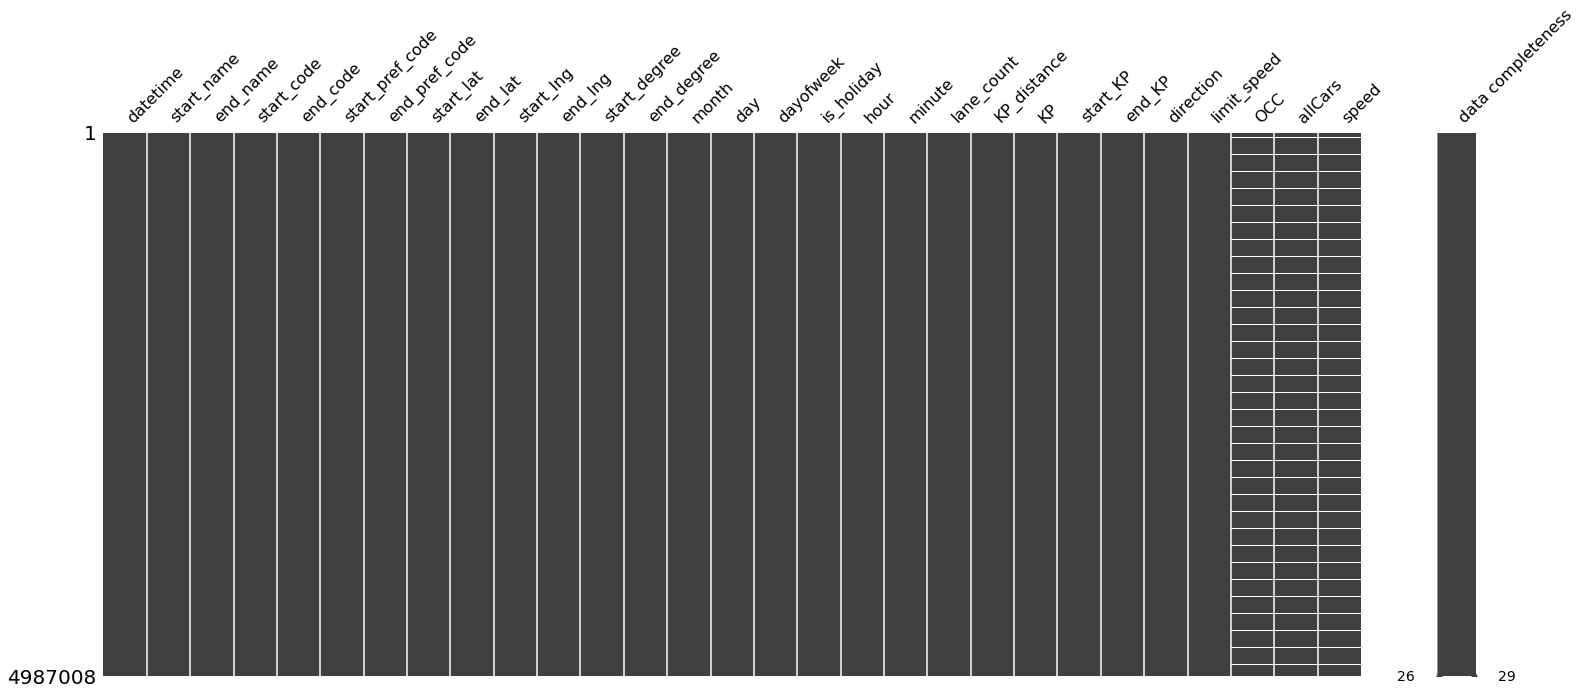

In [33]:
msno.matrix(df_traffic, labels=True)
plt.show()

In [34]:
OUTPUT_FILE = f'{PROCESSED_DATA_DIR}/{TARGET_ROAD}_{PERIOD}_2KP.csv'
OUTPUT_FILE

'../../Input_processed_data/touhoku_20240507-20240831_2KP.csv'

In [35]:
%time df_traffic.to_csv(OUTPUT_FILE, index=False)

CPU times: user 1min 39s, sys: 755 ms, total: 1min 39s
Wall time: 1min 40s


In [36]:
!head -n5 "$OUTPUT_FILE"

datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,month,day,dayofweek,is_holiday,hour,minute,lane_count,KP_distance,KP,start_KP,end_KP,direction,limit_speed,OCC,allCars,speed
2024-05-07 00:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.72369722222223,139.69075,4.0,4.0,5,7,2,0,0,0,3,5.7,5.47,4.8,10.5,下り,100.0,2.0,64.0,94.0
2024-05-07 00:00:00,岩槻,浦和本線,1040016,1040013,11,11,35.9347,35.89012,139.69075,139.72369722222223,4.0,4.0,5,7,2,0,0,0,3,5.7,5.6,10.5,4.8,上り,100.0,6.0,141.0,80.0
2024-05-07 00:00:00,浦和本線,岩槻,1040013,1040016,11,11,35.89012,35.9347,139.72369722222223,139.69075,4.0,4.0,5,7,2,0,0,0,1,5.7,7.3,4.8,10.5,下り,100.0,2.0,17.0,85.0
2024-05-07 00:00:00,岩槻,浦和本線,1040016,1040013,11,11,35.9347,35.89012,139.69075,139.72369722222223,4.0,4.0,5,7,2,0,0,0,3,5.7,7.3,10.5,4.8,上り,100.0,5.0,144.0,85.0


In [37]:
!tail -n5 "$OUTPUT_FILE"

2024-08-31 23:55:00,那須高原ＳＡ,那須,1040121,1040116,9,9,37.05368,37.00026,140.10424722222223,140.04276388888889,4.0,4.0,8,31,6,1,23,55,2,8.0,160.229,160.5,152.5,上り,100.0,1.0,14.0,97.0
2024-08-31 23:55:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,8,31,6,1,23,55,1,9.199999999999989,162.169,169.7,160.5,上り,100.0,2.0,15.0,91.0
2024-08-31 23:55:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,8,31,6,1,23,55,2,9.199999999999989,164.133,169.7,160.5,上り,100.0,1.0,21.0,91.0
2024-08-31 23:55:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,8,31,6,1,23,55,2,9.199999999999989,166.085,169.7,160.5,上り,100.0,1.0,18.0,90.0
2024-08-31 23:55:00,白河,那須高原ＳＡ,1040126,1040121,7,9,37.11645,37.05368,140.1675,140.10424722222223,4.0,4.0,8,31,6,1,23,55,2,9.199999999999989,168.082,169.7,160.5,上り,100.0,2.0,25.0,87.0
